Import libraries

In [5]:
import pandas as pd

Load Data

In [6]:
df = pd.read_csv(r'data\pizza_sales.csv')

df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1.0,1.0,hawaiian_m,1.0,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2.0,2.0,classic_dlx_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3.0,2.0,five_cheese_l,1.0,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4.0,2.0,ital_supr_l,1.0,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5.0,2.0,mexicana_m,1.0,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


Data Cleaning

In [7]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(df):
    # Change column type to int32 for columns: 'pizza_id', 'order_id', 'quantity'
    df = df.astype({'pizza_id': 'int32', 'order_id': 'int32', 'quantity': 'int32'})
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)
    return df

df_clean = clean_data(df.copy())

In [8]:
def convert_date(date_str):
    try:
        # Trying to convert dates from the 'dd-mm-yyyy' format
        return pd.to_datetime(date_str, format='%d-%m-%Y').strftime('%Y-%m-%d')
    except ValueError:
        # If it doesn't work, try the format 'm/d/yyyy'
        return pd.to_datetime(date_str, format='%m/%d/%Y').strftime('%Y-%m-%d')

df_clean['order_date'] = df_clean['order_date'].apply(convert_date)

df_clean.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


Database Schema

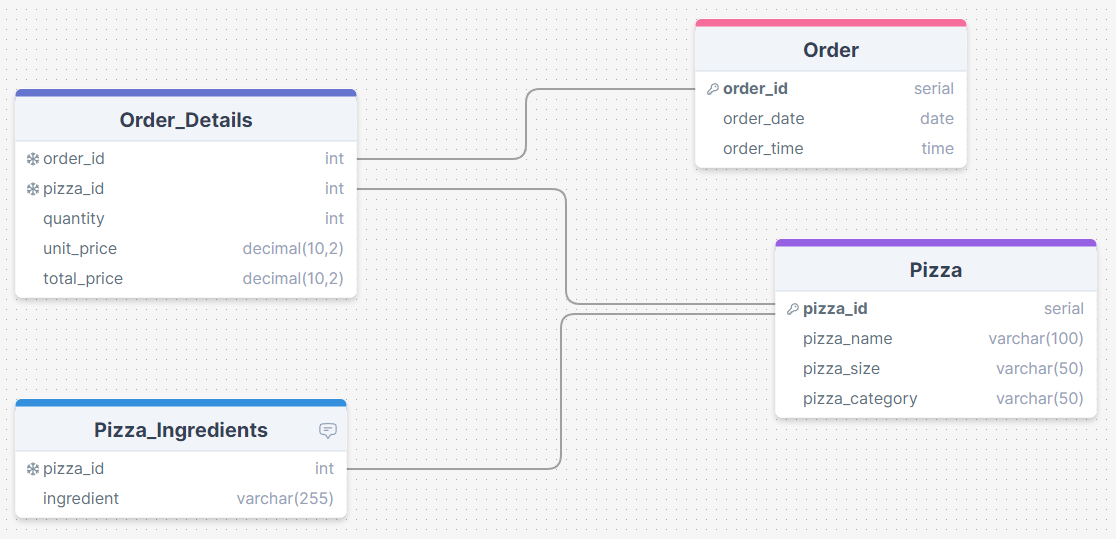

Create a database

In [ ]:
CREATE TABLE Order (
    order_id SERIAL PRIMARY KEY,
    order_date DATE NOT NULL,
    order_time TIME NOT NULL
);

CREATE TABLE Pizza (
    pizza_id SERIAL PRIMARY KEY,
    pizza_name VARCHAR(100) NOT NULL,
    pizza_size VARCHAR(50) NOT NULL,
    pizza_category VARCHAR(50) NOT NULL
);

CREATE TABLE Order_Details (
    order_details_id SERIAL PRIMARY KEY,
    order_id INTEGER REFERENCES Order(order_id),
    pizza_id INTEGER REFERENCES Pizza(pizza_id),
    quantity INTEGER NOT NULL,
    unit_price DECIMAL(10, 2) NOT NULL,
    total_price DECIMAL(10, 2) NOT NULL
);

CREATE TABLE Pizza_Ingredients (
    pizza_id INTEGER REFERENCES Pizza(pizza_id),
    ingredient VARCHAR(255) NOT NULL,
    PRIMARY KEY (pizza_id, ingredient)
);
